In [63]:
import pandas as pd
import numpy as np 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from  pmdarima.arima import auto_arima

from  pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import train_test_split
# from sktime.forecasting.model_selection import temporal_train_test_split



In [12]:
df = pd.read_csv("train.csv")
asset_details = pd.read_csv("asset_details.csv")
df.head()


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


# PART I : ARIMA MODEL 

## DATA FEATURES :

We can see the different features included in the dataset. Specifically, the features included per asset are the following:

timestamp: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.

1. Asset_ID: The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin). The mapping from Asset_ID to crypto asset is contained in asset_details.csv.

2. Count: Total number of trades in the time interval (last minute).

3. Open: Opening price of the time interval (in USD).

4. High: Highest price reached during time interval (in USD).

5. Low: Lowest price reached during time interval (in USD).

6. Close: Closing price of the time interval (in USD).

7. Volume: Quantity of asset bought or sold, displayed in base currency USD.

8. VWAP: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.

9. Target: Residual log-returns for the asset over a 15 minute horizon.

The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time. The last column is the prediction target, which we will get to later in more detail.

We also view the asset information, including the list of all assets, the Asset_ID to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [14]:
df.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423680e+07,2.348647e+07
mean,1.577120e+09,6.292544e+00,2.864593e+02,1.432640e+03,1.436350e+03,1.429568e+03,1.432640e+03,2.868530e+05,NaN,7.121752e-06
std,3.323350e+07,4.091861e+00,8.673982e+02,6.029605e+03,6.039482e+03,6.020261e+03,6.029611e+03,2.433935e+06,NaN,5.679042e-03
min,1.514765e+09,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,1.549011e+09,3.000000e+00,1.900000e+01,2.676500e-01,2.681600e-01,2.669000e-01,2.676483e-01,1.410725e+02,2.676368e-01,-1.694354e-03
50%,1.578372e+09,6.000000e+00,6.400000e+01,1.428860e+01,1.431250e+01,1.426300e+01,1.428920e+01,1.295415e+03,1.428769e+01,-4.289844e-05
75%,1.606198e+09,9.000000e+00,2.210000e+02,2.288743e+02,2.293000e+02,2.284200e+02,2.288729e+02,2.729764e+04,2.288728e+02,1.601520e-03
max,1.632182e+09,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


In [15]:
### NA CHECK 
df.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [16]:
### Check of asset_details dataframe
asset_details.head()


,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic


In [17]:
### Merge on Asset_ID the two dataframes to get the asset name and the weights
df = df.merge(asset_details)
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,Asset_Name
0,1514764860,2,40.0,2376.580000,2399.5,2357.14,2374.590000,19.233005,2373.116392,-0.004218,2.397895,Bitcoin Cash
1,1514764920,2,53.0,2374.553333,2400.9,2354.20,2372.286667,24.050259,2371.434498,-0.004079,2.397895,Bitcoin Cash
2,1514764980,2,61.0,2371.633333,2401.9,2353.70,2372.063333,42.676438,2375.442755,-0.002892,2.397895,Bitcoin Cash
3,1514765040,2,95.0,2376.060000,2406.4,2344.00,2370.566667,37.820918,2371.096152,-0.003718,2.397895,Bitcoin Cash
4,1514765100,2,33.0,2372.656667,2404.6,2343.40,2370.173333,8.519679,2370.345730,-0.002171,2.397895,Bitcoin Cash


In [18]:
### Conversion of timestamp to datetime, second 
df.timestamp=df.timestamp.astype("datetime64[s]")

In [19]:
df_eth = df.loc[df["Asset_Name"]=="Ethereum",:]
df_eth.head()


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,Asset_Name
9758705,2018-01-01 00:01:00,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809,5.894403,Ethereum
9758706,2018-01-01 00:02:00,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441,5.894403,Ethereum
9758707,2018-01-01 00:03:00,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206,5.894403,Ethereum
9758708,2018-01-01 00:04:00,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205,5.894403,Ethereum
9758709,2018-01-01 00:05:00,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744,5.894403,Ethereum


In [20]:
### Calculate the number of NA Target 
df_eth.isnull().sum()

timestamp       0
Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target        340
Weight          0
Asset_Name      0
dtype: int64

Notice that there are many gaps in the data. To work with most time series models, we should preprocess our data into a format without time gaps.
To check how many gaps there are, I  first create a data_range object that starts at our first timestamp and ends at our last timestamp with freq = 1 minute. 
So, to get the gaps in our data frame, we just subtract len(df_eth) from len(date_range). 

In [21]:
date_range = pd.date_range(df_eth.timestamp.iloc[0],df_eth.timestamp.iloc[-1],freq="1min")
gaps_number = len(date_range) - len(df_eth)
print("there is {} gaps".format(gaps_number)) 

there is 760 gaps


In this first Analyze we keep only Volume, VWAP, and Close features to forcast our logreturn.

We resample to get daily data as our goal at the end is to to daily trade.  
I'll do an other release where I'll analyze those data with freq =1min or 5min

In [22]:
df_eth=df_eth[["timestamp","Close","Volume","Asset_Name","VWAP"]]
df_eth.set_index("timestamp",drop=True,inplace=True)
df_eth = df_eth.resample("D").agg({'Close':'last','Volume':'sum',"Asset_Name":"last","VWAP":"mean"})
df_eth

,Close,Volume,Asset_Name,VWAP
timestamp,,,,
2018-01-01,755.872500,2.736363e+05,Ethereum,745.595580
2018-01-02,860.765000,8.519938e+05,Ethereum,847.150377
2018-01-03,938.377500,6.726274e+05,Ethereum,882.602543
2018-01-04,943.032500,7.463656e+05,Ethereum,946.636547
2018-01-05,962.335000,6.641310e+05,Ethereum,976.178427
...,...,...,...,...
2021-09-17,3399.250000,9.440272e+05,Ethereum,3480.378575
2021-09-18,3435.950000,7.305153e+05,Ethereum,3460.831992
2021-09-19,3328.497143,6.469277e+05,Ethereum,3381.870979


We check whether resampling to a lower frequency was sufficient to solve our gap problem by applying the same method with freq = Daily.

In [23]:
date_range = pd.date_range(df_eth.index[0],df_eth.index[-1],freq="D")
gaps_number = len(date_range) - len(df_eth)
print("there is {} gaps".format(gaps_number)) 



there is 0 gaps


In [24]:
df_eth.isnull().sum()

Close         0
Volume        0
Asset_Name    0
VWAP          0
dtype: int64

In [25]:
df_eth.describe()

,Close,Volume,VWAP
count,1360.000000,1.360000e+03,1360.000000
mean,709.253474,1.634466e+06,707.516560
std,879.515845,1.282952e+06,877.232573
min,83.606333,1.204826e+03,83.584277
25%,181.840060,7.789428e+05,182.269642
50%,284.009167,1.317649e+06,285.758035
75%,729.329357,2.046749e+06,727.231003
max,4175.517143,1.411873e+07,4211.757056


In [26]:
df_eth.corr()

,Close,Volume,VWAP
Close,1.000000,0.132787,0.999038
Volume,0.132787,1.000000,0.134687
VWAP,0.999038,0.134687,1.000000


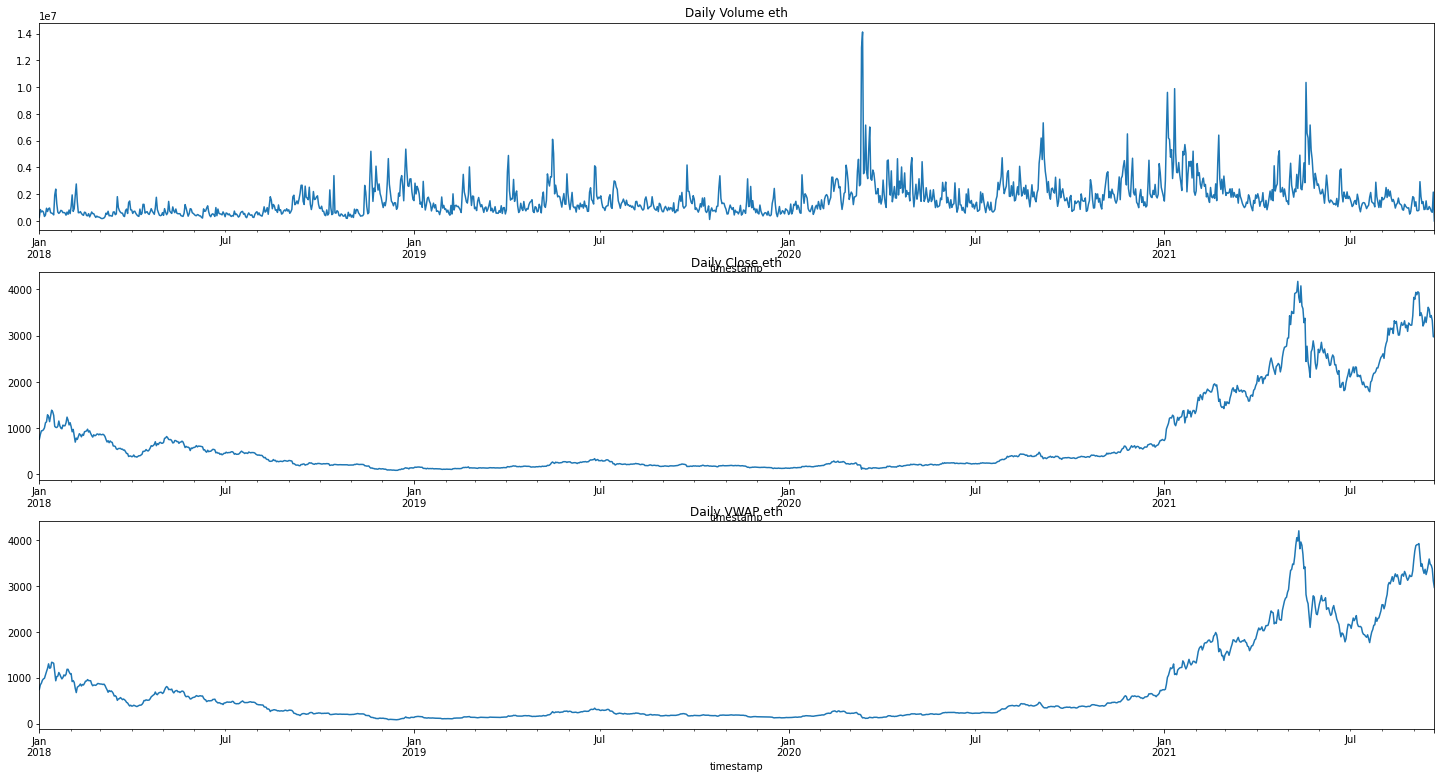

In [27]:
plt.figure(figsize=(25,13))
plt.subplot(3,1,1)
df_eth.Volume.plot()
plt.title("Daily Volume eth")
plt.subplot(3,1,2)
df_eth.Close.plot()
plt.title("Daily Close eth")
plt.subplot(3,1,3)
df_eth.VWAP.plot()
plt.title("Daily VWAP eth")
plt.show()


As we could expect VWAP and Close are strongly correlated so we ll for now keep just Close feature to our analysis

In [28]:
df_eth.drop("VWAP",axis=1,inplace=True)

In [64]:
import warnings
warnings.filterwarnings("ignore")

# Fundamentals
## Auto-Regressive and Moving Average Models
### Auto-Regressive (AR) Model
y^t=α1yt−1+⋯+αpyt−p 
<br>
The AR model assumes that the current value ( yt ) is dependent on previous values ( yt−1,yt−2,yt−3,... ). Because of this assumption, we can build a linear regression model.

To figure out the order of an AR model, you would use the PACF.

### Moving Average (MA) Model
y^t=ϵt+β1ϵt−1+⋯+βqϵt−q 
<br>
The MA model assumes that the current value ( yt ) is dependent on the error terms including the current error ( ϵt,ϵt−1,ϵt−2,ϵt−3,... ). Because error terms are random, there is no linear relationship between the current value and the error terms.

To figure out the order of an MA model, you would use the ACF.

### Stationarity
ACF and PACF assume stationarity of the underlying time series. Staionarity can be checked by performing an Augmented Dickey-Fuller (ADF) test:

1. p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
2. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
[...] We can see that our [ADF] statistic value [...] is less than the value [...] at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

If the time series is stationary, continue to the next steps. If the time series is not stationary, try differencing the time series and check its stationarity again.

In [29]:
def check_stationarity(series,col):
    result = adfuller(series[col])
    print('ADF Statistic : %f' % result[0])
    print('p-value %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
       print('\t%s: %.3f' % (key, value))
       
    if(result[1]<=0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
    

In [30]:
print(check_stationarity(df_eth,"Close"),check_stationarity(df_eth,"Volume"))

ADF Statistic : 0.149049
p-value 0.969255
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary
ADF Statistic : -6.099357
p-value 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary
None None


As expected Close price is not a stationary time serie.
We'll study the log return of ethereum (on the close price)

# Log returns
In order to analyze price changes for an asset we can deal with the price difference. However, different assets exhibit different price scales, so that the their returns are not readily comparable. We can solve this problem by computing the percentage change in price instead, also known as the return. This return coincides with the percentage change in our invested capital.

Returns are widely used in finance, however log returns are preferred for mathematical modelling of time series, as they are additive across time. Also, while regular returns cannot go below -100%, log returns are not bounded.

To compute the log return, we can simply take the logarithm of the ratio between two consecutive prices. The first row will have an empty return as the previous value is unknown, therefore the empty return data point will be dropped.

In [31]:
def log_ret(df):
    return np.log(df.Close.div(df.Close.shift(1)))

df_eth['log_ret']=log_ret(df_eth)
df_eth.dropna(axis=0,inplace=True)
df_eth

,Close,Volume,Asset_Name,log_ret
timestamp,,,,
2018-01-02,860.765000,8.519938e+05,Ethereum,0.129949
2018-01-03,938.377500,6.726274e+05,Ethereum,0.086331
2018-01-04,943.032500,7.463656e+05,Ethereum,0.004948
2018-01-05,962.335000,6.641310e+05,Ethereum,0.020262
2018-01-06,1003.155000,3.341171e+05,Ethereum,0.041543
...,...,...,...,...
2021-09-17,3399.250000,9.440272e+05,Ethereum,-0.048655
2021-09-18,3435.950000,7.305153e+05,Ethereum,0.010739
2021-09-19,3328.497143,6.469277e+05,Ethereum,-0.031773


In [32]:
df_eth.drop("Asset_Name", axis=1,inplace=True)

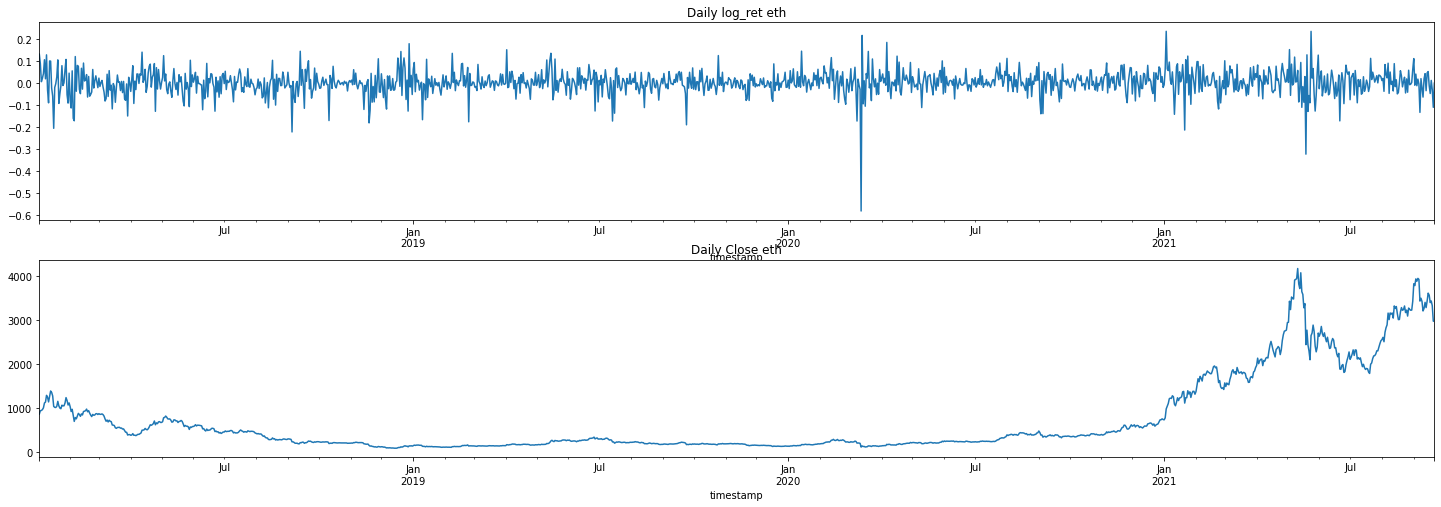

In [33]:
plt.figure(figsize=(25,8))
plt.subplot(2,1,1)
df_eth.log_ret.plot()
plt.title("Daily log_ret eth")
plt.subplot(2,1,2)
df_eth.Close.plot()
plt.title("Daily Close eth")
plt.show()

We can clearly see the covid peak in March 2020.



# ACF PACF STUDY

The data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

1. the ACF is exponentially decaying or sinusoidal;
2. there is a significant spike at lag p in the PACF, but none beyond lag   p.


The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

1. the PACF is exponentially decaying or sinusoidal;
2. there is a significant spike at lag q in the ACF, but none beyond lag q.

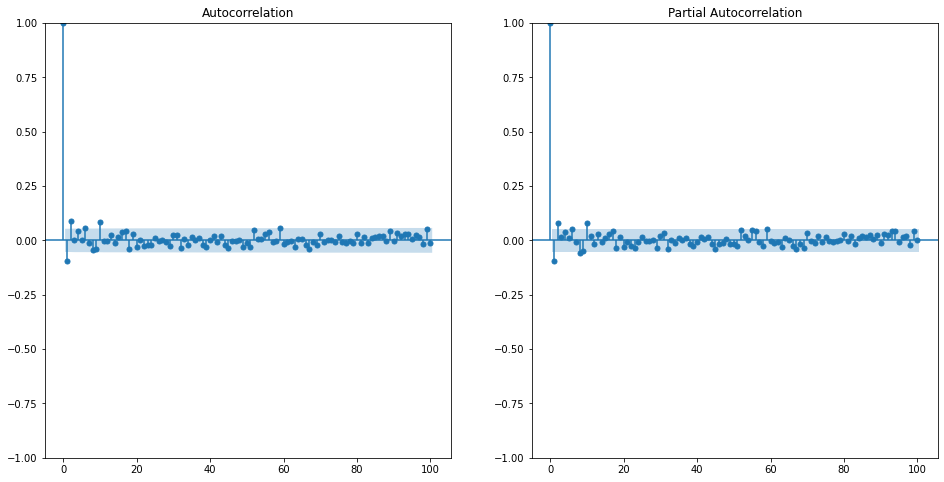

In [34]:

fig, axe=plt.subplots(1,2,figsize=(16,8))
plot_acf(df_eth.log_ret, ax=axe[0],lags=100)
plot_pacf(df_eth.log_ret, ax=axe[1],lags=100,method='ols')
plt.show()

The graphs suggest us to try a different combinations of ARIMA model with p,q in (1,2,10)²  

In [35]:
### Splitting the Data in train et test split, be carefull with timeserie data you want to keep the time order in your data so you can't shuffle your data 
df_eth_train, df_eth_test = df_eth.iloc[0:int(len(df_eth)*0.9),:],df_eth.iloc[int(len(df_eth)*0.9):,:]


# Time series decomposition
## Time series Components


If we assume an additive decomposition, then we can write 

<br>
yt = St + Tt + Rt
<br>

where yt is the data, St is the seasonal component,Tt is the trend-cycle component, and Rt is the remainder component, all at period t. Alternatively, a multiplicative decomposition would be written as

<br>
yt = St x Tt x Rt
<br>
 
The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.

As we can see the variation around the trend cycle vary with the level of the time so we use here a multiplicative decomposition

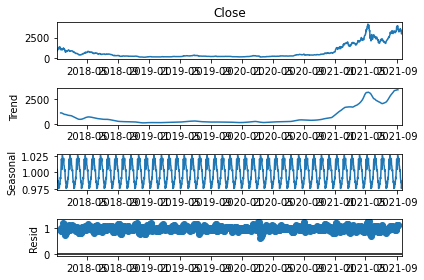

<Figure size 432x288 with 0 Axes>

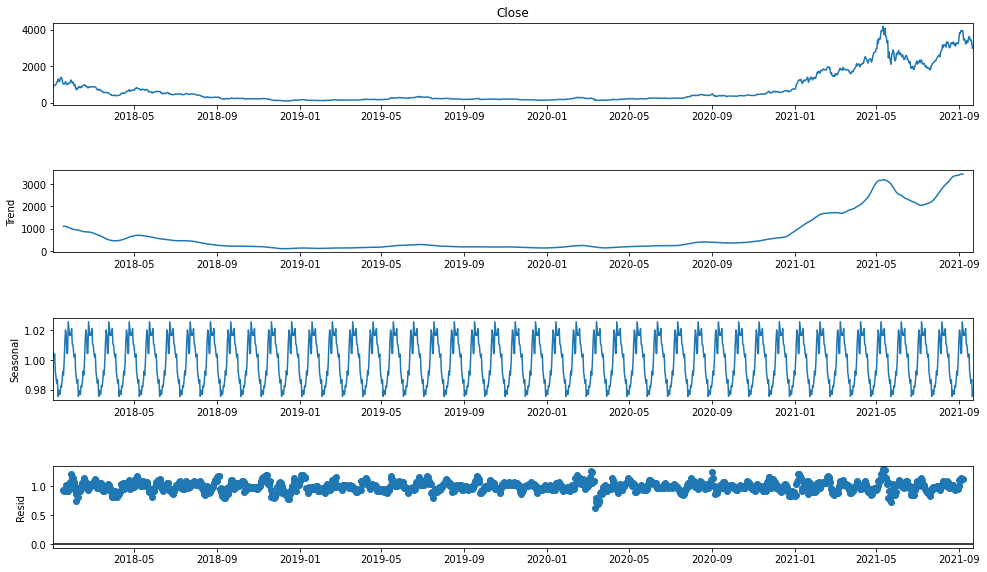

In [36]:
decomposed = seasonal_decompose(df_eth.Close, model="multiplicative", period=30)
decomposed.plot()
fig = plt.figure()
fig = decomposed.plot()
fig.set_size_inches(16,9)
plt.show()

As we see, the seasonal component is mostly white noise, ranging from 0.98 to 1.02, so as we would expect, there is no seasonal pattern in the closing price of ethereum.

We'll here use auto_arima methods from pmdarima.arima to select our p,d,q values.
It selects these values by taking the model with the lowest AIC, BIC, HQIC (a mixture between these validation metrics).

In [37]:
print("arima p,d,q model :")
print(auto_arima(df_eth_train.log_ret,start_p=7, start_q=7,d=0, max_p=8, max_q=8))
print('-'*40)
print("number of diff needed to get stationary serie:{}".format(ndiffs(df_eth_train.log_ret, test="adf")))
print(check_stationarity(df_eth,"log_ret"))

arima p,d,q model :
 ARIMA(2,0,1)(0,0,0)[0]          
----------------------------------------
number of diff needed to get stationary serie:0
ADF Statistic : -11.011609
p-value 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary
None


In [38]:
from statsmodels.tsa.arima.model import ARIMA as ARIMA 
model = ARIMA(df_eth_train.log_ret, order=(2,0,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                log_ret   No. Observations:                 1223
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1860.178
Date:                Tue, 30 Nov 2021   AIC                          -3710.357
Time:                        13:54:25   BIC                          -3684.812
Sample:                    01-02-2018   HQIC                         -3700.743
                         - 05-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.770      0.442      -0.002       0.005
ar.L1          0.5358      0.172      3.110      0.002       0.198       0.873
ar.L2          0.1273      0.026      4.973      0.0

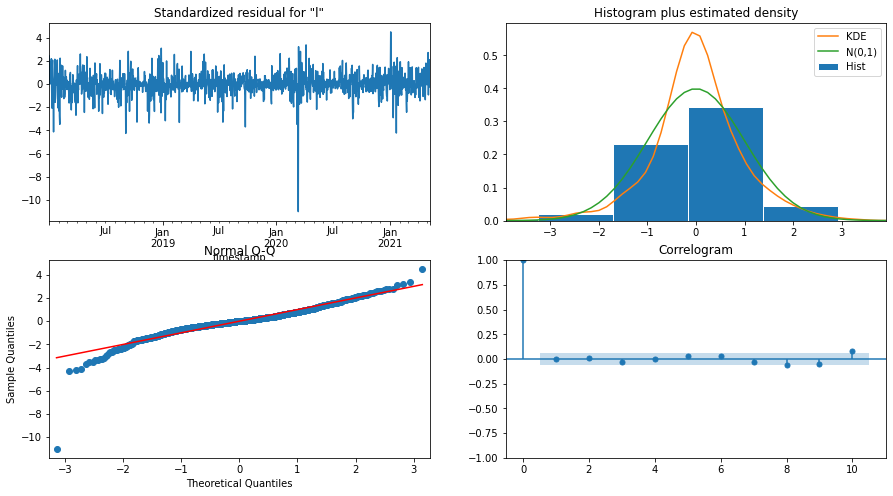

In [39]:
residuals = pd.DataFrame(model_fit.resid)
model_fit.plot_diagnostics(figsize=(15,8))
plt.show()

how should the plot diagnostics be interpreted?
<br>
<br>
<b>Topleft:</b> The residual errors appear to have a uniform variance and fluctuate around a mean of zero.
<br>
<br>
<b>Top Right:</b> The density plot on the top right suggests a normal distribution with a mean of zero.
<br>
<br>
<b>Bottom left:</b> The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.
<br>
<br>
<b>Bottom Right:</b> The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

In [40]:
acorr_ljungbox(residuals,model_df=3,lags=[60], return_df=True)

,lb_stat,lb_pvalue
60,62.712091,0.28093


On peut dont accepter l'hypothese : residual ~ white noise  



In [41]:
history = [x for x in df_eth_train.log_ret]
model_predictions = []
N_test_observations = len(df_eth_test)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,0,1))
    model_fit = model.fit(method_kwargs={"warn_convergence": False})
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = df_eth_test.log_ret[time_point]
    history.append(true_test_value)
    
    
MSE_error = mean_squared_error(df_eth_test.log_ret, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))    

Testing Mean Squared Error is 0.003970654857790512


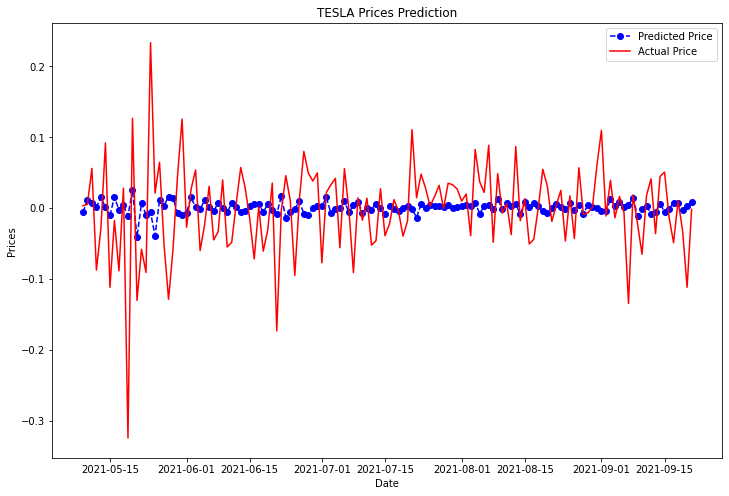

In [42]:
plt.figure(figsize=(12,8))
test_set_range = df_eth_test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, df_eth_test.log_ret, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()



Our model failed to capture the magnitude of the returns. 
We could argue now that the magnitude of forcasted returns is not that relevant, but rather wether the direction is correctly forcasted or not

In [43]:
## we can get the direction with the np.sign
predict=np.sign(model_predictions)
real_return=np.sign(df_eth_test.log_ret)

df_eth_test["pred"]=predict
df_eth_test


C:\Users\ahmet\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Close,Volume,log_ret,pred
timestamp,,,,
2021-05-09,3925.867143,2.178004e+06,0.003381,-1.0
2021-05-10,3947.687723,3.478770e+06,0.005543,1.0
2021-05-11,4175.517143,2.428278e+06,0.056108,1.0
2021-05-12,3826.547879,3.694140e+06,-0.087275,1.0
2021-05-13,3719.082857,4.915556e+06,-0.028486,1.0
...,...,...,...,...
2021-09-17,3399.250000,9.440272e+05,-0.048655,1.0
2021-09-18,3435.950000,7.305153e+05,0.010739,1.0
2021-09-19,3328.497143,6.469277e+05,-0.031773,-1.0


If the model predicted well the direction so predict * real_return = 1 otherwise =-1

In [44]:

accuary=pd.DataFrame(predict * np.array(real_return))
accuary_counts=accuary.value_counts()

In [45]:
hits = accuary_counts[1.0]/sum(accuary_counts) *100
hits ## percentage of correctly forcasted market direction

58.08823529411765

In [65]:
df_eth_test["strategy"] = df_eth_test.log_ret * df_eth_test.pred 
df_eth_test["creturns"] = df_eth_test.log_ret.cumsum().apply(np.exp)
df_eth_test["arima_strategy"] = df_eth_test.strategy.cumsum().apply(np.exp)

### to take into account transactions fees 

ptc = 0.000059 *16.9 # theorical proportional trading cost 
df_eth_test["trades"] = df_eth_test.pred.diff().abs() 
df_eth_test.trades.value_counts()

df_eth_test["strategy_net"] = df_eth_test.strategy - df_eth_test.trades *ptc
df_eth_test["arima_strategy_net"] =  df_eth_test["strategy_net"].cumsum().apply(np.exp)

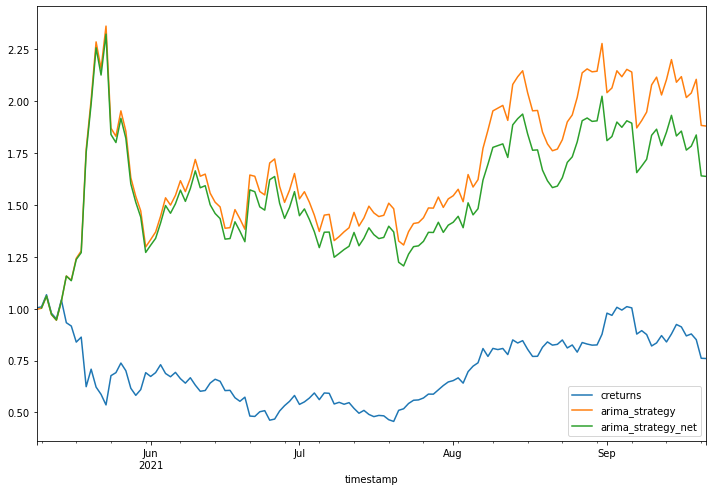

In [47]:
df_eth_test[["creturns","arima_strategy","arima_strategy_net"]].plot(figsize=(12,8))
plt.show()

# PART II - ARDL models

Autoregressive Distributed Lag (ARDL) models extend Autoregressive models with lags of explanatory variables. While ARDL models are technically AR-X models, the key difference is that ARDL models focus on the exogenous variables and selecting the correct lag structure from both the endogenous variable and the exogenous variables. ARDL models are also closely related to Vector Autoregressions, and a single ARDL is effectively one row of a VAR. The key distinction is that an ARDL assumes that the exogenous variables are exogenous in the sense that it is not necessary to include the endogenous variable as a predictor of the exogenous variables.

![title](ARDL.png)

# Feature engineering

In [48]:
window = 50
p=2
df = df_eth.copy()
df["dir"] = np.where(df.log_ret>0,1,0)
df["sma"] = df.Close.rolling(30).mean() - df.Close.rolling(window+100).mean() #proxy for SMA strategy
df["boll"] = (df.Close-df.Close.rolling(window).mean())/(df.Close-df.Close.rolling(window).std())
df["mom"] = df.log_ret.rolling(p).mean() #proxy for  Momentum strategy
df["vol"] = df.log_ret.rolling(window).std()
df["min"] = df.Close.rolling(window).min()/df.Close -1
df["max"] = df.Close.rolling(window).max()/df.Close -1
df.dropna(inplace=True)
print(df.shape)
features = ["Volume","dir","sma","boll","mom","vol","min","max" ]


(1210, 10)


In [83]:
cols_lag1 = []
for f in features : 
    col = "{}_lag_{}".format(f,1)
    df[col]=df[f].shift(1)
    cols_lag1.append(col)

df.dropna( inplace=True )


we first have to check that yt and all of the predictors appear to be stationary. If we estimate the model when any of these are non-stationary, the estimated coefficients will not be consistent estimates (and therefore may not be meaningful).<br>
We therefore first difference the non-stationary variables in the model. It is often desirable to maintain the form of the relationship between yt and the predictors, and consequently it is common to difference all of the variables if any of them need differencing. The resulting model is then called a “model in differences,” as distinct from a “model in levels,” which is what is obtained when the original data are used without differencing.

In [51]:
for f in cols_lag1 :
    print(check_stationarity(df,f))

ADF Statistic : -6.092411
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -38.488534
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -2.602866
p-value 0.092406
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary
None
ADF Statistic : -5.488759
p-value 0.000002
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -6.988603
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -3.637348
p-value 0.005086
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -3.966876
p-value 0.001594
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -4.501777
p-value 0.000195
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None


The 3rd feature isn't stationary so we ll take the first difference of all the features 

In [52]:
cols = []
for f in cols_lag1 : 
    col = "{}_diff_{}".format(f,1)
    df[col]=df[f].diff(1)
    cols.append(col)

df.dropna(inplace=True)
df

,Close,Volume,log_ret,dir,sma,boll,mom,vol,min,max,...,min_lag_1,max_lag_1,Volume_lag_1_diff_1,dir_lag_1_diff_1,sma_lag_1_diff_1,boll_lag_1_diff_1,mom_lag_1_diff_1,vol_lag_1_diff_1,min_lag_1_diff_1,max_lag_1_diff_1
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-02,590.672000,4.074634e+05,0.020053,1,-83.773832,-0.114464,0.011347,0.053579,-0.149261,0.381193,...,-0.144622,0.409170,-7.260056e+04,0.0,-1.734900,0.000707,0.009984,-0.003347,-0.000533,-0.003727
2018-06-03,619.384000,3.907975e+05,0.047465,1,-87.103576,-0.058968,0.033759,0.053918,-0.188206,0.317167,...,-0.149261,0.381193,-8.271286e+04,0.0,-3.910163,0.023143,-0.007845,0.000053,-0.004639,-0.027977
2018-06-04,590.965000,4.751259e+05,-0.046969,0,-92.123342,-0.119722,0.000248,0.053757,-0.149167,0.380508,...,-0.188206,0.317167,-1.666596e+04,0.0,-3.329743,0.055496,0.022412,0.000339,-0.038944,-0.064026
2018-06-05,608.548333,4.501586e+05,0.029320,1,-95.563464,-0.085875,-0.008825,0.053483,-0.173751,0.340620,...,-0.149167,0.380508,8.432845e+04,-1.0,-5.019767,-0.060754,-0.033511,-0.000161,0.039038,0.063341
2018-06-06,606.461667,3.732452e+05,-0.003435,0,-97.048559,-0.093546,0.012942,0.053412,-0.156190,0.345233,...,-0.173751,0.340620,-2.496735e+04,1.0,-3.440122,0.033847,-0.009073,-0.000274,-0.024584,-0.039888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17,3399.250000,9.440272e+05,-0.048655,0,664.087423,0.053184,-0.030732,0.045344,-0.275439,0.162410,...,-0.332244,0.107207,2.103239e+05,-1.0,9.180365,-0.021228,-0.028785,0.000087,0.031374,0.014091
2021-09-18,3435.950000,7.305153e+05,0.010739,1,665.273356,0.057841,-0.018958,0.045194,-0.269967,0.149994,...,-0.275439,0.162410,-1.332319e+05,0.0,5.698810,-0.057011,-0.049776,0.000556,0.056804,0.055203
2021-09-19,3328.497143,6.469277e+05,-0.031773,0,660.508775,0.018467,-0.010517,0.045417,-0.246399,0.187119,...,-0.269967,0.149994,-2.135119e+05,1.0,1.185933,0.004657,0.011774,-0.000150,0.005473,-0.012416


In [53]:
for f in cols :
    print(check_stationarity(df,f))

ADF Statistic : -13.140148
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -12.022121
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -6.915259
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -9.867534
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -11.605925
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -12.798394
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -20.112597
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None
ADF Statistic : -10.326959
p-value 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
None


After the first diff all the series seem to be stationary 

In [54]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

In [55]:
col_st=[col for col in cols if col !='dir_lag_1_diff_1']
col_st

['Volume_lag_1_diff_1',
 'sma_lag_1_diff_1',
 'boll_lag_1_diff_1',
 'mom_lag_1_diff_1',
 'vol_lag_1_diff_1',
 'min_lag_1_diff_1',
 'max_lag_1_diff_1']

In [56]:
mu, std = df[col_st].mean(), df[col_st].std()
df[col_st] =(df[col_st] - mu) / std
df[col_st].isna().sum()


Volume_lag_1_diff_1    0
sma_lag_1_diff_1       0
boll_lag_1_diff_1      0
mom_lag_1_diff_1       0
vol_lag_1_diff_1       0
min_lag_1_diff_1       0
max_lag_1_diff_1       0
dtype: int64

In [57]:
df[col_st].describe()

,Volume_lag_1_diff_1,sma_lag_1_diff_1,boll_lag_1_diff_1,mom_lag_1_diff_1,vol_lag_1_diff_1,min_lag_1_diff_1,max_lag_1_diff_1
count,1.208000e+03,1208.000000,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03
mean,-1.102871e-17,0.000000,-7.720094e-18,8.087717e-18,-5.146729e-18,5.881976e-18,1.249920e-17
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.042221e+01,-7.048030,-1.554130e+01,-8.002468e+00,-1.718502e+01,-5.313987e+00,-6.375490e+00
25%,-3.835068e-01,-0.172632,-2.703420e-01,-5.457370e-01,-1.221264e-01,-5.073303e-01,-3.601585e-01
50%,-2.764677e-02,-0.005235,3.981303e-03,-1.671245e-02,-4.337341e-05,3.021101e-04,8.903482e-04
75%,3.409993e-01,0.146946,3.300068e-01,5.567354e-01,1.117893e-01,4.947788e-01,3.177127e-01
max,1.003694e+01,4.531729,7.645470e+00,6.829852e+00,1.918074e+01,6.562589e+00,1.454567e+01


In [58]:
df_train, df_test = df.iloc[0:int(len(df)*0.9),:],df.iloc[int(len(df)*0.9):,:]
df_test.head()


,Close,Volume,log_ret,dir,sma,boll,mom,vol,min,max,...,min_lag_1,max_lag_1,Volume_lag_1_diff_1,dir_lag_1_diff_1,sma_lag_1_diff_1,boll_lag_1_diff_1,mom_lag_1_diff_1,vol_lag_1_diff_1,min_lag_1_diff_1,max_lag_1_diff_1
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-05-24,2649.314286,5.287263e+06,0.233491,1,1228.533207,-0.074197,0.071409,0.083880,-0.258887,0.576075,...,-0.063973,0.990584,2.898201,0.0,-2.065542,-1.988273,0.553907,0.256661,2.212497,2.166433
2021-05-25,2706.242857,4.591131e+06,0.021260,1,1227.567700,-0.049996,0.127376,0.083900,-0.274477,0.542920,...,-0.258887,0.576075,-1.851418,1.0,0.039394,4.450800,4.088049,2.738373,-5.313987,-5.201327
2021-05-26,2887.390000,3.385178e+06,0.064792,1,1224.653347,0.028048,0.043026,0.084323,-0.319994,0.446122,...,-0.274477,0.542920,-0.686402,0.0,-0.165712,0.264758,1.571512,0.011400,-0.424759,-0.415207
2021-05-27,2742.395714,2.436931e+06,-0.051521,0,1213.746795,-0.046272,0.006635,0.083966,-0.246377,0.522580,...,-0.319994,0.446122,-1.188146,0.0,-0.371836,0.854303,-2.363801,0.177813,-1.240723,-1.213963
2021-05-28,2411.732079,3.555749e+06,-0.128487,0,1191.298069,-0.243507,-0.090004,0.085762,-0.143051,0.731335,...,-0.246377,0.522580,-0.934523,-1.0,-1.217149,-0.813959,-1.018743,-0.144922,2.007461,0.960467


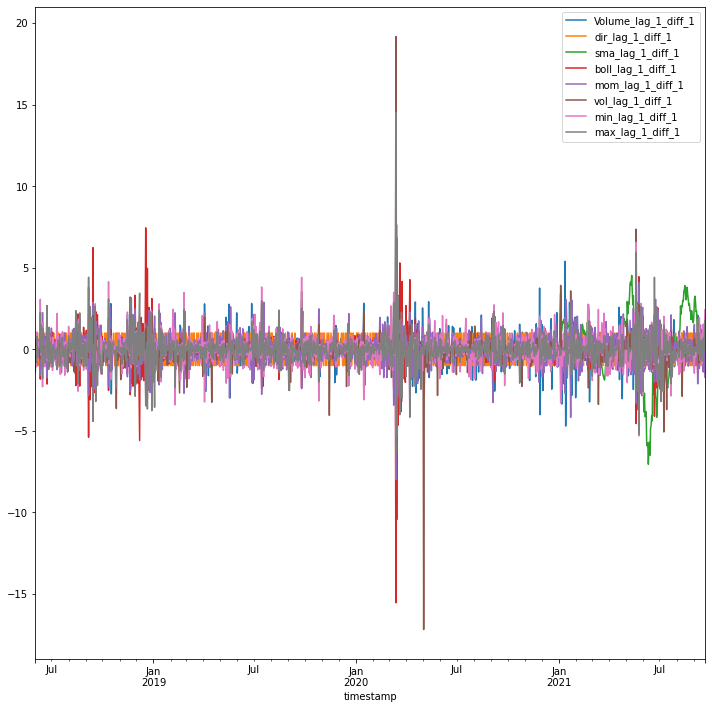

In [59]:
df[cols].plot(figsize=(12,12))
plt.show()

In [67]:
sel_res = ardl_select_order(
    df_train.log_ret, 3, df_train[selected_col], 3, ic="aic", trend="c",seasonal=False
)
print(f"The optimal order is: {sel_res.model.ardl_order}")

The optimal order is: (1, 2, 1, 3, 1)


While the ardl_order shows the largest included lag of each variable, ar_lags and dl_lags show the specific lags included, there the model selected only 3 features, the ardl_order gives us the max order that minimize the aic 

In [68]:
selected_col = []
for key in sel_res.dl_lags:
    selected_col.append(key)

selected_col

['sma_lag_1_diff_1',
 'mom_lag_1_diff_1',
 'min_lag_1_diff_1',
 'max_lag_1_diff_1']

We see that the model select only those columns : ['dir_lag_1_diff_1',
                                                   'mom_lag_1_diff_1',
                                                   'min_lag_1_diff_1',
                                                   'max_lag_1_diff_1] <br>
so we ll retrain the model with onlt those columns to make faster our running time 

In [69]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARDL Model Results                              
===============================================================================
Dep. Variable:                 log_ret   No. Observations:                 1087
Model:             ARDL(1, 2, 1, 3, 1)   Log Likelihood                1677.083
Method:                Conditional MLE   S.D. of innovations              0.052
Date:                 Tue, 30 Nov 2021   AIC                          -3326.165
Time:                         14:48:07   BIC                          -3256.302
Sample:                     06-05-2018   HQIC                         -3299.719
                          - 05-23-2021                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0011      0.002      0.659      0.510      -0.002       0.004
log_ret.L1              0.1741      0.110      1.586      0.113      -0.041       0.389
sma_lag_1_diff_1.L0    -0.0226      0.010     -2.174      0.030      -0.043      -0.002
sma_lag_1_diff_1.L1     0.0422      0.013      3.255      0.001       0.017       0.068
sma_lag_1_diff_1.L2    -0.0213      0.010     -2.113      0.035      -0.041      -0.002
mom_lag_1_diff_1.L0    -0.0116      0.005     -2.413      0.016      -0.021      -0.002
mom_lag_1_diff_1.L1    -0.0113      0.004     -2.771      0.006      -0.019      -0.003
min_lag_1_diff_1.L0    -0.0048      0.004     -1.305      0.192      -0.012       0.002
min_lag_1_diff_1.L1    -0.0076      0.003     -2.405      0.016      -0.014      -0.001
min_lag_1_diff_1.L2     0.0068      0.004      1.883      0.060      -0.000       0.014
min_lag_1_diff_1.L3     0.0067      0.003      2.104      0.036       0.000       0.013
max_lag_1_diff_1.L0     0.0099      0.004      2.808      0.005       0.003       0.017
max_lag_1_diff_1.L1    -0.0062      0.003     -2.052      0.040      -0.012      -0.000
=======================================================================================
"""

In [70]:
res.forecast(exog=df_train[selected_col])[0]

-0.04361871628392479

In sample test prediction :

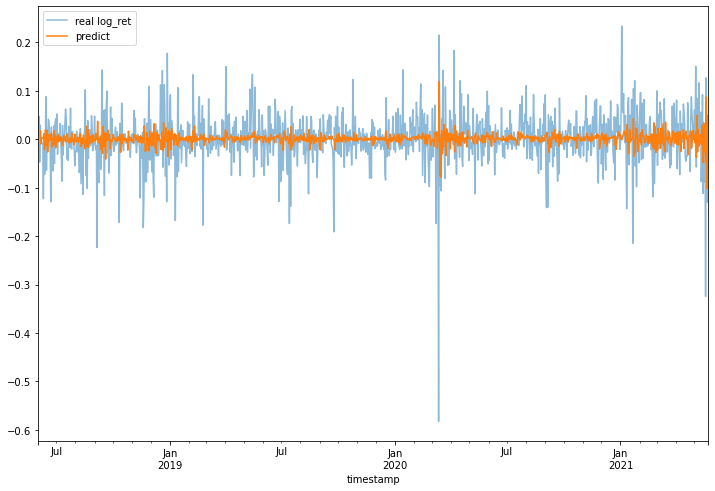

In [71]:
plt.figure(figsize=(12,8))
df_train.log_ret.plot(label='real log_ret', alpha=0.5)
res.predict().plot(label="predict")
plt.legend()

In [72]:
history_y =  [y for y in df_train.log_ret]
history_x =  df_train[selected_col]
model_predictions = []
N_test_observations = len(df_test)

for time_point in range(N_test_observations):
    model = ARDL(history_y, 2, history_x[selected_col], {"sma_lag_1_diff_1": 2, "mom_lag_1_diff_1": 1, "min_lag_1_diff_1": 3,"max_lag_1_diff_1":1}, trend="c")
    model_fit = model.fit()
    output = model_fit.forecast(exog=history_x[selected_col])
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = df_test.log_ret[time_point]
    history_y.append(true_test_value)
    history_x=history_x.append(df_test[selected_col].iloc[time_point,])
    

In [73]:
MSE_error = mean_squared_error(df_test.log_ret, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 0.00366765610001786


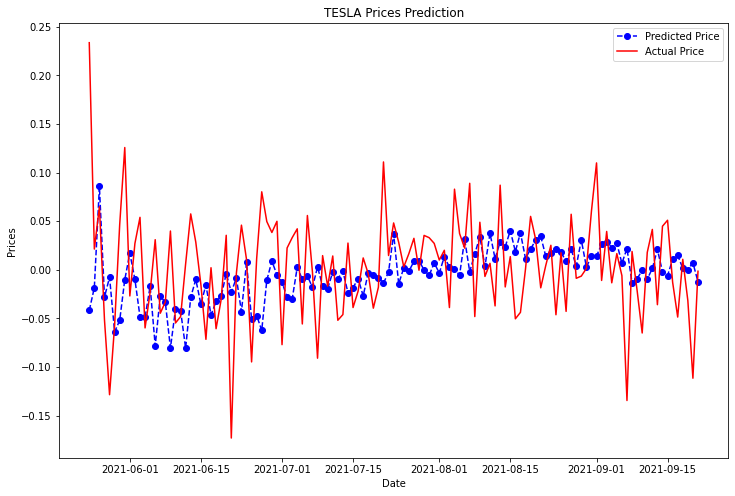

In [74]:
plt.figure(figsize=(12,8))
test_set_range = df_test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, df_test.log_ret, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()

In [75]:
predict=np.sign(model_predictions)
real_return=np.sign(df_test.log_ret)

df_test["pred"]=predict
accuary=pd.DataFrame(predict * np.array(real_return))
accuary_counts=accuary.value_counts()
hits = accuary_counts[1.0]/sum(accuary_counts) *100
hits ## percentage of correctly forcasted market direction

48.760330578512395

# Conclusion 

The ARDL model with those features give a better RMSE but he is worse at predicting direction

# PART III (optional)
## PRICE FORCAST

Price prediction doesn't make much sense to me, but we can also try it (for fun). <br>
There we are doing the very same thing applied to close feature instead of log_ret

In [76]:
print("arima p,d,q model :")
print(auto_arima(df_eth_train.Close,start_p=2, start_q=2,d=None, max_p=8, max_q=8))
print('-'*40)
print("number of diff needed :{}".format(ndiffs(df_eth_train.Close, test="adf")))

arima p,d,q model :
 ARIMA(2,2,6)(0,0,0)[0]          
----------------------------------------
number of diff needed :1


In [78]:
model = ARIMA(df_eth_train.Close, order=(2,2,6))
model_fit = model.fit()
print(model_fit.summary())




                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1223
Model:                 ARIMA(2, 2, 6)   Log Likelihood               -6218.765
Date:                Tue, 30 Nov 2021   AIC                          12455.530
Time:                        14:50:04   BIC                          12501.497
Sample:                    01-02-2018   HQIC                         12472.831
                         - 05-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5860      0.027     21.315      0.000       0.532       0.640
ar.L2         -0.7524      0.029    -26.010      0.000      -0.809      -0.696
ma.L1         -1.6807      0.031    -54.982      0.0

Testing Mean Squared Error is 33927.870169505964


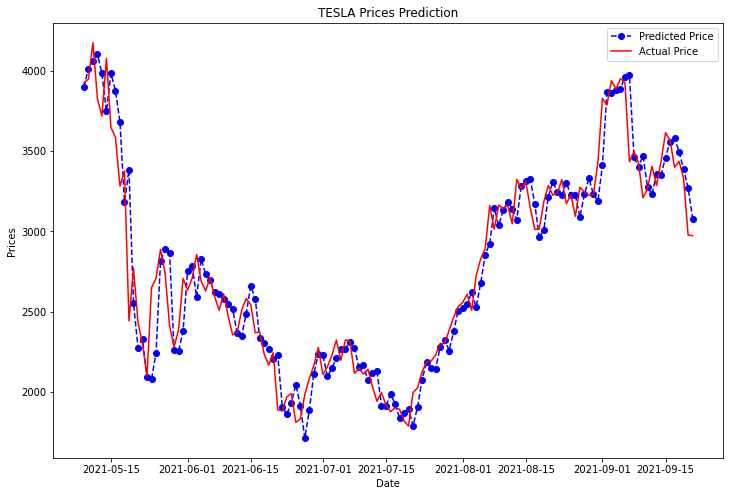

In [79]:
history = [x for x in df_eth_train.Close]
model_predictions = []
N_test_observations = len(df_eth_test)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,2,6))
    model_fit = model.fit(method_kwargs={"warn_convergence": False})
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = df_eth_test.Close[time_point]
    history.append(true_test_value)
    
    
MSE_error = mean_squared_error(df_eth_test.Close, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))
   
plt.figure(figsize=(12,8))
test_set_range = df_eth_test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, df_eth_test.Close, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()

In [81]:
predict=np.sign(pd.DataFrame(model_predictions)-pd.DataFrame(model_predictions).shift(1)).dropna(axis=0)
test=np.sign(pd.DataFrame(df_eth_test.Close)-pd.DataFrame(df_eth_test.Close).shift(1)).dropna(axis=0)
accuary=pd.DataFrame(predict * np.array(test))
accuary.value_counts()


-1.0    76
 1.0    59
dtype: int64

# Conclusion

the daily forecast is quite bad even if graphically it looks good 